In [1]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("final_unprocessed_data.csv")

In [3]:
df

,LBXTR,SEQN,LBXTC,LBXBAPCT,LBXHGB,LBXPLTSI,LBXRDW,LBXMC,LBXRBCSI,LBXMPSI,...,LBXT4,LBXPCT,LBXHP1,LBXLA,LBXLACL,LBXTBA,LBXTBM,LBXTBIN,LBXTBN,RIDAGEYR
0,40.0,109264.0,166.0,0.5,13.7,263.0,13.1,33.7,4.80,8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
1,84.0,109271.0,147.0,1.0,15.3,254.0,13.7,34.4,4.54,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0
2,133.0,109274.0,105.0,0.8,13.9,173.0,13.9,33.6,4.47,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0
3,24.0,109277.0,129.0,0.4,12.9,224.0,13.3,33.4,4.41,8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
4,132.0,109282.0,233.0,1.2,12.9,154.0,14.5,33.9,4.16,7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106198,NaN,102936.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
106199,NaN,102937.0,NaN,0.7,12.6,390.0,13.7,33.4,4.56,5.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
106200,NaN,102938.0,NaN,0.8,13.1,357.0,12.8,33.8,4.74,5.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
106201,NaN,102939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [14]:
cohort = df[(df.RIDAGEYR >= 1) & (df.RIDAGEYR <= 85)]

In [15]:
thresh = len(cohort) * 0.05
cohort = cohort.dropna(thresh=thresh, axis = 1)
thresh2 = 20
cohort = cohort.dropna(thresh=thresh2, axis=0)

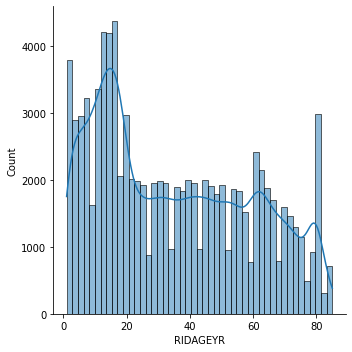

In [26]:
sns.displot(cohort, x="RIDAGEYR", kde=True)

In [17]:
from sklearn.model_selection import train_test_split
y = cohort["RIDAGEYR"]
X = cohort.drop(columns=["RIDAGEYR"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])
X_train = my_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = my_pipeline.transform(X_test)

In [19]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("stdv:", scores.std())


In [20]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = [
#    {
#     'n_estimators': [25, 50, 100, 200, 400,500],
#     'max_features': [1, 5, 10, 25, 50, 100],
#     'bootstrap': [True, False]
#     }
# ]

# forest_reg = RandomForestRegressor()
# grid_search = RandomizedSearchCV(forest_reg, param_grid , cv = 5,
#                                 scoring='neg_mean_squared_error', n_iter=5,
#                                 n_jobs=-1)
# grid_search.fit(X_train, y_train)
# f = open("best_params.txt", "w")
# f.write(str(grid_search.best_params_))
# f.close()

In [21]:
start_time = time.time()
forest_reg = RandomForestRegressor(n_estimators= 100, max_features= 100, bootstrap= False, n_jobs=-1)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features=100, n_jobs=-1)

In [23]:
from sklearn.model_selection import cross_val_score
start_time = time.time()
score = cross_val_score(forest_reg, X_train, y_train,
                         scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
forest_mae_scores = -score
display_scores(forest_mae_scores)

Scores: [4.62885465 4.69568214 4.74858369 4.74376402 4.79805717]
Mean: 4.722988334633315
stdv: 0.057146932913469596


In [22]:
from sklearn.metrics import r2_score
r2_score(y_test, forest_reg.predict(X_test))

0.9240642255707596

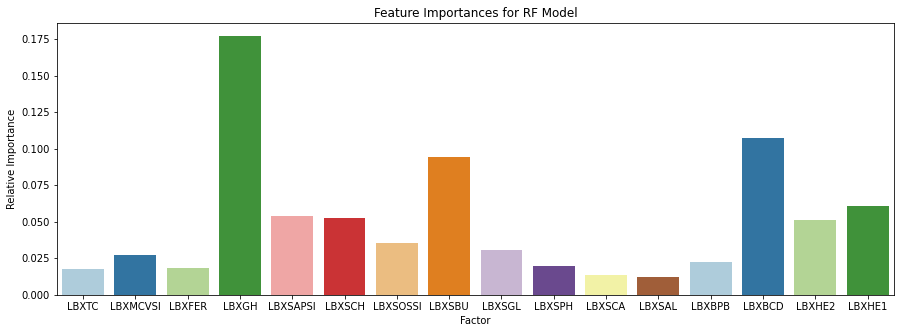

In [28]:
varimp = []
for name, score in zip(X.columns, forest_reg.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');